##get test data & utils.py file

In [1]:
import os
from google.colab import auth

project_id = 'doc-localization-al'

test_folder = 'smartDocData_DocTestC.zip'
test_lab = 'gt-test.csv'
to_download = [test_folder, test_lab, 'utils.py']
tmp = 'data'


auth.authenticate_user()
os.system(f'gcloud config set project {project_id}')
os.system(f'mkdir /content/{tmp}')

for s in to_download:
  os.system(f'gsutil cp gs://doc-local-data/{s} /content/{tmp}/{s}')

!unzip /content/{tmp}/{test_folder} -d /content/{tmp}/


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/smartDocData_DocTestC/background02magazine005.avi103.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01patent005.avi112.jpg  
  inflating: /content/data/smartDocData_DocTestC/background04patent005.avi060.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax003.avi119.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax005.avi072.jpg  
  inflating: /content/data/smartDocData_DocTestC/background04datasheet005.avi049.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax005.avi066.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01patent005.avi106.jpg  
  inflating: /content/data/smartDocData_DocTestC/background04patent005.avi074.jpg  
  inflating: /content/data/smartDocData_DocTestC/background02magazine005.avi117.jpg  
  inflating: /content/data/smartDocData_DocTestC/background01tax002.avi203.jpg  
  inflating: /content/data/sma

In [2]:
import numpy as np
import csv
import time
import cv2
from IPython.display import clear_output

class LoadingBar():
  def __init__(self, len):
    self.bar = list('[' + ' '*50 + ']')
    self.stepsz = len/50
    self.ind = 1
  
  def step(self, place):
    if(int(place%self.stepsz)==0):
      self.bar[self.ind] = '='
      if(self.ind<50):
        self.bar[self.ind+1] = '>'
        self.ind = self.ind+1
      clear_output(wait=True)
      print(''.join(self.bar))

class Dataset():
  def __init__(self, directory, labels, size):
    self.data=np.empty((size,64,64,3), dtype=np.uint8)
    self.coords=np.empty((size,8))

    dat = open(labels,newline='\n')
    datr = csv.reader(dat)
    counter = 0
    start = time.time()
    br = LoadingBar(size)
    for row in datr:
      img = cv2.imread(os.path.join(directory,row[0]))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      
      self.data[counter] = img
      self.coords[counter] = np.array(row[1:]).astype('float')
      br.step(counter)
      counter += 1
    dat.close()
    print(f'{size} units loaded in {time.time()-start} seconds')

In [3]:
test_sz = len(os.listdir('/content/data/smartDocData_DocTestC'))-1

In [4]:
testData = Dataset('/content/data/smartDocData_DocTestC','/content/data/gt-test.csv', test_sz)

[==================================================]
6158 units loaded in 1.475428819656372 seconds


In [5]:
os.chdir('/content/data')
from utils import *

##get predicition data

In [6]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

%cd /content/gdrive/MyDrive/NYU4/NYU4.1_MDL/DS301-Final-project/predictions/

Mounted at /content/gdrive/
/content/gdrive/.shortcut-targets-by-id/1X3xLPUaj56eGriAwVLEyWRk22UtvU5Ao/DS301-Final-project/predictions


##calc IoU & generate comparison box plots

###prediction model 1 (feature extraction, no fine tuning)

In [51]:
import pandas as pd
import numpy as np

pred0 = pd.read_csv('./predictions_nft.csv')

pred0 = np.array(pred0)

pred0.shape

(6158, 8)

In [52]:
len(pred0)

6158

In [53]:
#generate IoU for pred0
iou_pred0 = []

for i in range(len(pred0)):
  temp_gt = np.reshape(testData.coords[i],(4,2))
  temp_pred0 = np.reshape(pred0[i],(4,2))
  iou0 = intrArea(temp_gt, temp_pred0)
  iou_pred0.append(iou0)

Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.


In [54]:
len(iou_pred0)

6158

In [55]:
avg_iou0 = np.array(iou_pred0).mean()

In [57]:
print('Average IoU - model 1 (no fine tuning):', avg_iou0)

Average IoU - model 1 (no fine tuning): 0.3699371099105995


intersection of union = 0.20666029510180217


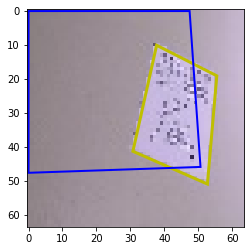

In [18]:
sample_img, sample_pts = testData.data[0], testData.coords[0]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 
comp_pts = np.reshape(pred0[0], (4,2))*64

plot_with_box(sample_img, sample_pts, compare_box=comp_pts)

###model 2 (partial fine tuning - 8 layers)

In [32]:
import pandas as pd
import numpy as np

pred1 = pd.read_csv('./predictions_pft.csv')
pred1 = np.array(pred1)

In [21]:
pred1.shape

(6158, 8)

In [28]:
pred1[0]

array([0.4978183 , 0.21102105, 0.81478214, 0.21657422, 0.86813235,
       0.8033856 , 0.481657  , 0.7129527 ])

In [23]:
pred1[0]

array([0.51181114, 0.24570021, 0.7887287 , 0.17844719, 0.8342509 ,
       0.7272994 , 0.4477694 , 0.71236354])

In [45]:
#generate IoU for pred1
iou_pred1 = []
num_errors = 0

for i in range(len(pred1)):
  #print(i)
  try:
    temp_gt = np.reshape(testData.coords[i],(4,2))
    temp_pred1 = np.reshape(pred1[i],(4,2))
    iou1 = intrArea(temp_gt, temp_pred1)
    iou_pred1.append(iou1)
  except:
    print('error at prediction', i)
    num_errors += 1

print(num_errors)
avg_iou1 = np.array(iou_pred1).mean()

error at prediction 41
Capping area_inter.
Capping area_inter.
Capping area_inter.
error at prediction 1637
Capping area_inter.
Capping area_inter.
Capping area_inter.
error at prediction 2053
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
3


GEOSException: ignored

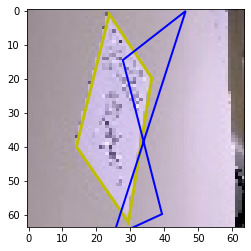

In [39]:
#image of exception 1 (index=41)
sample_img, sample_pts = testData.data[41], testData.coords[41]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 
comp_pts = np.reshape(pred1[41], (4,2))*64

plot_with_box(sample_img, sample_pts, compare_box=comp_pts)

GEOSException: ignored

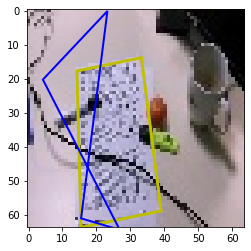

In [47]:
#image of exception 2 (index=1637)
sample_img, sample_pts = testData.data[1637], testData.coords[1637]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 
comp_pts = np.reshape(pred1[1637], (4,2))*64

plot_with_box(sample_img, sample_pts, compare_box=comp_pts)

GEOSException: ignored

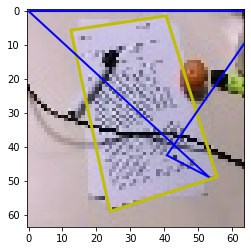

In [48]:
#image of exception 1 (index=2053)
sample_img, sample_pts = testData.data[2053], testData.coords[2053]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 
comp_pts = np.reshape(pred1[2053], (4,2))*64

plot_with_box(sample_img, sample_pts, compare_box=comp_pts)

In [41]:
pred1[41]*64

array([27.76741952, 14.42582144, 46.24566656,  0.        , 24.86190208,
       66.4054464 , 39.2885824 , 59.75835776])

In [58]:
#doesn't take into account images whose predictions threw exceptions
print('Average IoU - model 2 (partial fine tuning - 8 layers):', avg_iou1)

Average IoU - model 2 (partial fine tuning - 8 layers): 0.6931368219515448


intersection of union = 0.7229509106223639


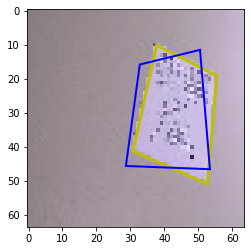

In [49]:
sample_img, sample_pts = testData.data[0], testData.coords[0]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 
comp_pts = np.reshape(pred1[0], (4,2))*64

plot_with_box(sample_img, sample_pts, compare_box=comp_pts)

###model 3 (full fine tuning)

In [59]:
pred2 = pd.read_csv('./predictions_fft.csv')
pred2 = np.array(pred2)

#generate IoU for pred2
iou_pred2 = []

for i in range(len(pred2)):
  temp_gt = np.reshape(testData.coords[i],(4,2))
  temp_pred2 = np.reshape(pred2[i],(4,2))
  iou2 = intrArea(temp_gt, temp_pred2)
  iou_pred2.append(iou2)

avg_iou2 = np.array(iou_pred2).mean()

Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.
Capping area_inter.


In [60]:
print('Average IoU - model 3 (full fine tuning):', avg_iou2)

Average IoU - model 3 (full fine tuning): 0.8217538408415215


intersection of union = 0.8142775566214873


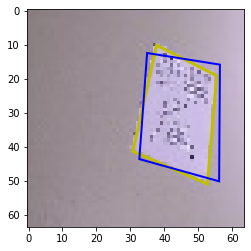

In [21]:
sample_img, sample_pts = testData.data[0], testData.coords[0]

#coordinates are normalized to be 0-1, to get actual coordinates multiply by 64
sample_pts = np.reshape(sample_pts,(4,2))*64 
comp_pts = np.reshape(pred2[0], (4,2))*64

plot_with_box(sample_img, sample_pts, compare_box=comp_pts)